#HW5

References:
*   https://keras.io/examples/generative/conditional_gan/

Collaborated and discussed with: Ramki, Rahul and Sushant


##GPU Check

In [ ]:
#Path: TensorFlow/Tejas/
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.4092955369999345
GPU (s):
0.036382874000082666
GPU speedup over CPU: 11x


##Dependencies

In [ ]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import  Dense, Dropout, Activation, Flatten
from librosa.core import stft,istft
import soundfile as sf
from sklearn.model_selection import train_test_split
import tensorflow as tf
import librosa
import itertools

import imageio
%matplotlib inline



##Load Dataset

In [ ]:
(X_train,y_train),(X_test,y_test)=keras.datasets.mnist.load_data()

In [ ]:
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

X_train:  (60000, 28, 28)
X_test:  (10000, 28, 28)
y_train:  (60000,)
y_test:  (10000,)


In [ ]:
X_train = X_train.reshape(-1,784)
X_test = X_test.reshape(-1,784)

In [ ]:
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)

X_train:  (60000, 784)
X_test:  (10000, 784)


##Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
rescale=MinMaxScaler(feature_range=(-1,1))

In [ ]:
X_train_sc=rescale.fit_transform(X_train)
X_test_sc=rescale.fit_transform(X_test)

In [ ]:
print("X_train_sc: ",X_train_sc.shape)
print("X_test_sc: ",X_test_sc.shape)

X_train_sc:  (60000, 784)
X_test_sc:  (10000, 784)


In [ ]:
batch_size = 100
num_classes = 10
image_size = 784 #Flatten image
latent_dim = 100

In [ ]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

y_train:  (60000, 10)
y_test:  (10000, 10)


In [ ]:
all_image = np.concatenate([X_train_sc,X_test_sc])
all_image = all_image.astype('float32')
all_label = np.concatenate([y_train,y_test])

In [ ]:
all_image.shape

(70000, 784)

In [ ]:
all_label.shape

(70000, 10)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((all_image, all_label))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [ ]:
print("Shape of training images: {}".format(all_image.shape))
print("Shape of training labels: {}".format(all_label.shape))

Shape of training images: (70000, 784)
Shape of training labels: (70000, 10)


In [ ]:

gen_input = latent_dim + num_classes
dis_input = image_size + num_classes
print("Generator Input Size:",gen_input)
print("Discriminator Input Size:",dis_input)

Generator Input Size: 110
Discriminator Input Size: 794


##Model
Following Professors model an keeping leaky relu and tanh activations.



In [ ]:
# Following Profssors Model.
discriminator = keras.Sequential(
    [   
        keras.layers.InputLayer((dis_input,)),
        layers.Dense(400,kernel_initializer = tf.keras.initializers.HeNormal(), activation = tf.nn.leaky_relu),
        layers.Dense(200,kernel_initializer = tf.keras.initializers.HeNormal(), activation = tf.nn.leaky_relu),
        layers.Dense(100,kernel_initializer = tf.keras.initializers.HeNormal(), activation = tf.nn.leaky_relu),
        layers.Dense(1,kernel_initializer = tf.keras.initializers.HeNormal())
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((gen_input,)),
        layers.Dense(200,kernel_initializer = tf.keras.initializers.HeNormal()),
        layers.BatchNormalization(momentum=0.5),
        layers.Dense(400,kernel_initializer = tf.keras.initializers.HeNormal()),
        layers.BatchNormalization(momentum=0.5),
        layers.Dense(784,kernel_initializer = tf.keras.initializers.HeNormal(),activation='tanh')
    ],
    name="generator",
)

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 400)               318000    
                                                                 
 dense_36 (Dense)            (None, 200)               80200     
                                                                 
 dense_37 (Dense)            (None, 100)               20100     
                                                                 
 dense_38 (Dense)            (None, 1)                 101       
                                                                 
Total params: 418,401
Trainable params: 418,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 200)               22200     
                                                                 
 batch_normalization_12 (Bat  (None, 200)              800       
 chNormalization)                                                
                                                                 
 dense_47 (Dense)            (None, 400)               80400     
                                                                 
 batch_normalization_13 (Bat  (None, 400)              1600      
 chNormalization)                                                
                                                                 
 dense_48 (Dense)            (None, 784)               314384    
                                                                 
Total params: 419,384
Trainable params: 418,184
Non-train

In [ ]:
class Cond_GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(Cond_GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.real_acc_tracker = tf.keras.metrics.BinaryAccuracy(name="real_acc")
        self.fake_acc_tracker = tf.keras.metrics.BinaryAccuracy(name="fake_acc")
    
    def make_labels(self):
        new_labels = []
        for i in range(100):
            if(i%10==0):
              vector = [0,0,0,0,0,0,0,0,0,0]
              vector[i//10] = 1
            new_labels.append(vector)
        new_labels = np.array(new_labels)
        return new_labels

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker,self.real_acc_tracker,self.fake_acc_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(Cond_GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    def train_step(self, data):
        real_images, one_hot_labels = data

        one_hot_labels = tf.cast(one_hot_labels, tf.float32)

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        generated_images = self.generator(random_vector_labels)
        
        fake_image_and_labels = tf.concat([generated_images, one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, one_hot_labels], -1)
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        self.fake_acc_tracker.update_state(labels[:batch_size,:],predictions[:batch_size,:])
        self.real_acc_tracker.update_state(labels[batch_size:,:],predictions[batch_size:,:])

        new_labels = self.make_labels()

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, new_labels], axis=1)

        misleading_labels = tf.zeros((batch_size, 1))

        

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, new_labels], -1)
            predictions1 = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions1)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "real_acc": self.real_acc_tracker.result(),
            "fake_acc": self.fake_acc_tracker.result()
        }

In [ ]:
cond_gan = Cond_GAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

history = cond_gan.fit(dataset, epochs=100,batch_size=128)

Epoch 1/100
700/700 [==============================] - 5s 5ms/step - g_loss: 6.7073 - d_loss: 0.0481 - real_acc: 0.9910 - fake_acc: 0.9648
Epoch 2/100
700/700 [==============================] - 3s 5ms/step - g_loss: 7.9461 - d_loss: 0.0894 - real_acc: 0.9764 - fake_acc: 0.9424
Epoch 3/100
700/700 [==============================] - 3s 5ms/step - g_loss: 3.9883 - d_loss: 0.2512 - real_acc: 0.9141 - fake_acc: 0.8125
Epoch 4/100
700/700 [==============================] - 3s 5ms/step - g_loss: 3.2866 - d_loss: 0.4204 - real_acc: 0.8883 - fake_acc: 0.7411
Epoch 5/100
700/700 [==============================] - 3s 5ms/step - g_loss: 2.6666 - d_loss: 0.4262 - real_acc: 0.8797 - fake_acc: 0.7107
Epoch 6/100
700/700 [==============================] - 3s 5ms/step - g_loss: 2.1003 - d_loss: 0.4703 - real_acc: 0.8683 - fake_acc: 0.6682
Epoch 7/100
700/700 [==============================] - 3s 5ms/step - g_loss: 2.2152 - d_loss: 0.4687 - real_acc: 0.8679 - fake_acc: 0.6777
Epoch 8/100
700/700 [======

##Plot

Text(0.5, 1.0, 'Accuracies')

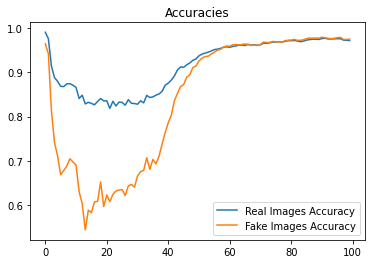

In [ ]:
plt.plot(history.history['real_acc'],label='Real Images Accuracy')
plt.plot(history.history['fake_acc'],label='Fake Images Accuracy' )
plt.legend(loc="best")
plt.title("Accuracies")

##Visualize

4/4 [==============================] - 0s 2ms/step


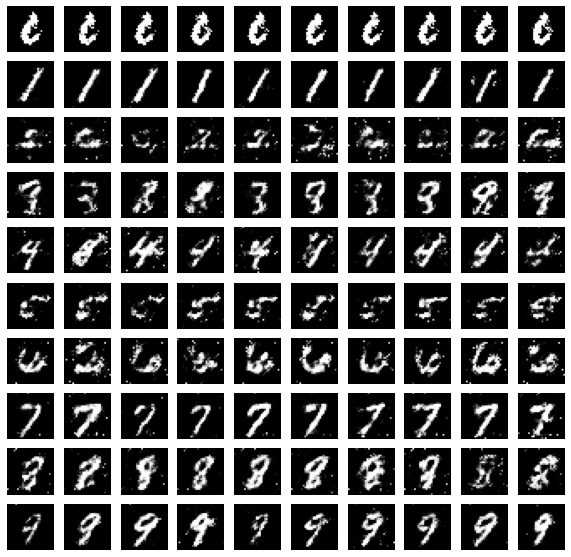

In [ ]:

noise = np.random.normal(0,1,(100, latent_dim))

labels=[]
for x in np.eye(10):
  for i in range(10):
    labels.append(x.tolist())
labels = np.array(labels)

image = cond_gan.generator.predict(np.concatenate([noise,labels],axis=1))
image = 0.5 * image + 0.5
fig, ax = plt.subplots(10,10, figsize = (10,10))
cnt = 0
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(image[cnt,:].reshape((28,28)),cmap = 'gray')
        ax[i,j].axis('off')
        cnt+=1
plt.show()
     

In [1]:
%%shell
jupyter nbconvert --to html 

[NbConvertApp] WARNING | pattern '/content/Deep_Learning_HW5_Q3.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=T

CalledProcessError: ignored